# Cell Tracking (Project 6)

**Group 12: Maximilian Karhausen, Johannes Simon**

**Background:** When testing a pharmacological drug onto cells, the effect on the cell population growth and 
overall phenotype is usually assessed by a single snapshot image. While these population and 
time-averaged measurements can highlight big scale effects between cell populations and 
conditions, they are an indirect measure of responses to chemotherapeutic drugs. Another 
approach is to record long videos of these cell populations while subjected to the drugs. These 
live observations are more accurate in capturing the proliferation behavior than standard 
approaches. Manual tracking of each single cell in the visual field is very time-consuming.

**Approach:** Given pre-detected cancer cells (in COCO format), we investigate suitable methods to match detections across frames (tracking). To do this, we compare the tracking methods SORT and DeepSORT with each other.

In [70]:
# Get all necessary imports
import json
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

## Part 1: Load the dataset, prepare the data and classify the cells

In [72]:
# Initialize local paths
# Dataset path
# Hint: (change to "/scratch/cv-course/jsimon10/dataset_jpg/dataset" when working on RAMSES)
ROOT_DIR = Path("dataset_jpg/dataset")
# Annotations file path
# Hint: (change to "/scratch/cv-course/jsimon10/dataset_jpg/dataset/annotations.json" when working on RAMSES)
ANN_FILE = Path("annotations.json")
# Create folder for cropped cells, needed later to train appearance model for DeepSORT
CROP_DIR = Path("cell_crops")
CROP_DIR.mkdir(exist_ok=True)

In [74]:
# Load the COCO annotations from the annotations.json file
with ANN_FILE.open("r") as f:
    coco = json.load(f)
# Get category name by their ID
cat_name_by_id = {cat["id"]: cat["name"] for cat in coco["categories"]}
# Group all annotations by their image ID to find all cells for each image more easily
annots_by_img = {}
for ann in coco["annotations"]:
    annots_by_img.setdefault(ann["image_id"], []).append(ann)
# Print summary info on the dataset once loaded
print("Loaded dataset with:")
print(f"  - {len(coco['images'])} images")
print(f"  - {len(coco['annotations'])} annotations")
print(f"  - {len(coco['categories'])} categories:")
for cat_id, cat_name in cat_name_by_id.items():
    print(f"    ID {cat_id}: {cat_name}")

Loaded dataset with:
  - 40350 images
  - 2204912 annotations
  - 2 categories:
    ID 1: living_cell
    ID 2: dead_cell


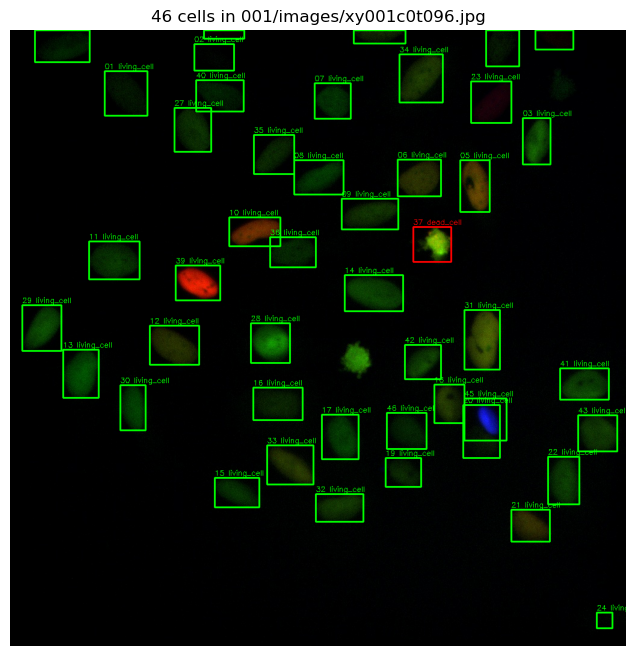

In [82]:
# Get an image by an selected index for visualization
img_by_idx = coco["images"][95] # For testing, only index of 0-449 works. Original dataset: up to 40349
# Get the path to the image
img_path = ROOT_DIR / img_by_idx["file_name"]
# Raise an error if image does not exist
if not img_path.exists():
    raise FileNotFoundError(f"Image file not found: {img_path}")
# Load the image and turn from BGR to RGB
img_rgb = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
# Get annotations for the selected image
annots = annots_by_img.get(img_by_idx["id"], [])
# Apply different colors for bounding boxes of different classes
bbox_color_map = {
    "living_cell": (0, 255, 0),     # green for living cell
    "dead_cell": (255, 0, 0),     # red for dead cell
}
# Draw bounding boxes based on annotations
for i, ann in enumerate(annots):
    # Get center x and y coordinates of the bounding box with width and height
    x_center, y_center, width, height = ann["bbox"]
    # For correct drawing (and SORT later), convert center-based x and y coordinates to top-left
    x, y = x_center - width / 2, y_center - height / 2
    # For correct drawing, turn float values to int values - OpenCV expects int values
    x_draw, y_draw, width_draw, height_draw = int(x), int(y), int(width), int(height)
    # Get the classified category and the respective color
    cat_id = ann["category_id"]
    cat_name = cat_name_by_id.get(cat_id, "unknown") # Edge case: If annotation without category exist, label as "unknown"
    label = f"{i+1:02d} {cat_name}"
    color = bbox_color_map.get(cat_name, (255, 255, 255)) # Edge case: If annotation without category exist, color white
    # Draw the bounding boxes and the text with the classified category 
    cv2.rectangle(img_rgb, (x_draw, y_draw), (x_draw + width_draw, y_draw + height_draw), color, 2)
    cv2.putText(img_rgb, label, (x_draw, y_draw - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
# Show classification result
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"{len(annots)} cells in {img_by_idx['file_name']}")
plt.show()